# Unexpected Examples, e.g., Adversarial Examples

Tree ensembles can behave erratically for unexpected examples.

Tree ensembles are susceptible to evasion attacks. An evasion attack constructs an adversarial example specifically designed to fool the ensemble to make the wrong prediction.

## Preliminaries

In [1]:
%load_ext autoreload
%autoreload 2

import time
from sklearn import datasets
from sklearn.model_selection import train_test_split
import numpy as np

## The MNIST dataset of handwritten digits

We use the [MNIST dataset](http://yann.lecun.com/exdb/mnist/).

In [2]:
X_mc, y_mc = datasets.fetch_openml(data_id=554, return_X_y=True, as_frame=False)

/home/laurens/venv/veritas/lib/python3.11/site-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


We construct a binary classification task by contrasting 2 and 4s.

In [3]:
class0, class1 = '2', '8'
mask = (y_mc == class0) | (y_mc == class1)
X = X_mc[mask, :]
yn = y_mc[mask]
y = yn == class1

Use a train and test set.

In [4]:
xtrain, xtest, ytrain, ytest, ytrain_n, ytest_n = train_test_split(X, y, yn, test_size=0.2, shuffle=True, random_state=13)

## Train the classifier

In [5]:
import veritas
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

In [6]:
params = {
    "n_estimators": 20,
    "eval_metric": "error",
    
    "tree_method": "hist",
    "seed": 135,
    "max_depth": 4,
    "learning_rate": 0.4
}
model = xgb.XGBClassifier(**params)

t = time.time()
model.fit(X, y)
print(f"XGB trained in {time.time()-t} seconds")

XGB trained in 0.8113822937011719 seconds


In [7]:
ytrain_pred = model.predict(xtrain)
ytest_pred = model.predict(xtest)
acc_train = accuracy_score(ytrain, ytrain_pred)
acc_test = accuracy_score(ytest, ytest_pred)

print(f"Train acc: {acc_train:.3f}, test acc: {acc_test:.3f} wrt true labels")

Train acc: 0.998, test acc: 0.996 wrt true labels


# Generate adversarial examples

In [8]:
# FROM CLASS 0 -> CLASS 1
number_of_adv_examples = 6

rng = np.random.default_rng(seed=159)
subset = rng.choice(range(xtest.shape[0]), number_of_adv_examples)

eps = 50

def noticks(ax):
    for x in ax:
        x.set_xticks([])
        x.set_yticks([])

In [9]:
at = veritas.get_addtree(model)

base_score according to XGB: 0.5
base_score set to 0.0 if base_score was 0.5


true_label=2, objective=MAX_OUTPUT done in 0.39ms
    RAW:  -5.0527 -> 6.7420
          -5.0527 -> 6.7420
    PROB: 0.0064 -> 0.9988
          0.0064 -> 0.9988


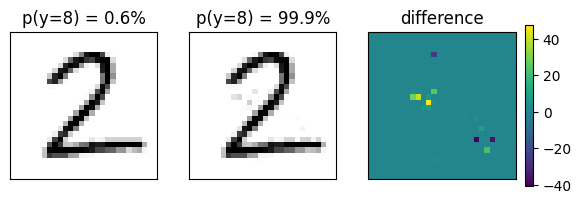


true_label=8, objective=MIN_OUTPUT done in 0.30ms
    RAW:  5.1248 -> -3.3550
          5.1248 -> -3.3550
    PROB: 0.9941 -> 0.0337
          0.9941 -> 0.0337


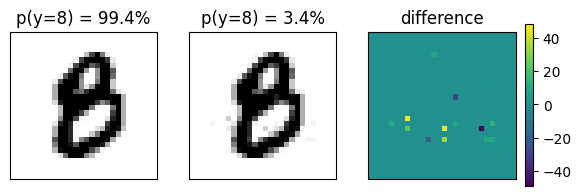


true_label=8, objective=MIN_OUTPUT done in 0.09ms
    RAW:  7.3296 -> -0.9579
          7.3296 -> -0.9579
    PROB: 0.9993 -> 0.2773
          0.9993 -> 0.2773


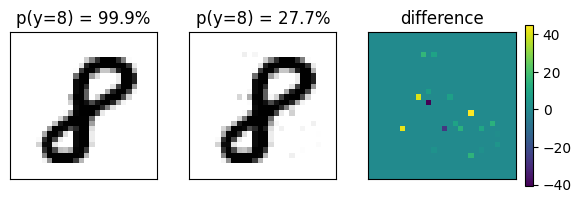


true_label=2, objective=MAX_OUTPUT done in 0.38ms
    RAW:  -5.1071 -> 6.7448
          -5.1071 -> 6.7448
    PROB: 0.0060 -> 0.9988
          0.0060 -> 0.9988


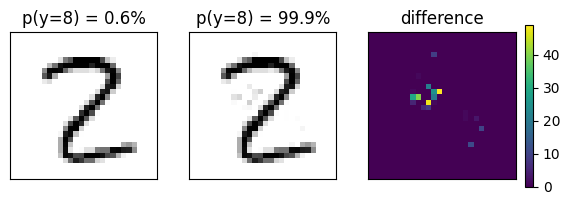


true_label=2, objective=MAX_OUTPUT done in 0.39ms
    RAW:  -3.5408 -> 7.8931
          -3.5408 -> 7.8931
    PROB: 0.0282 -> 0.9996
          0.0282 -> 0.9996


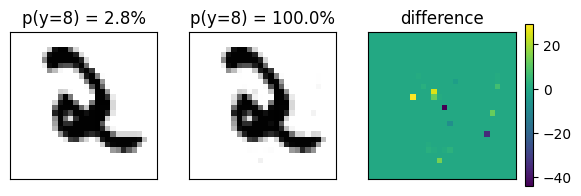


true_label=2, objective=MAX_OUTPUT done in 0.45ms
    RAW:  -4.9982 -> 6.9576
          -4.9982 -> 6.9576
    PROB: 0.0067 -> 0.9990
          0.0067 -> 0.9990


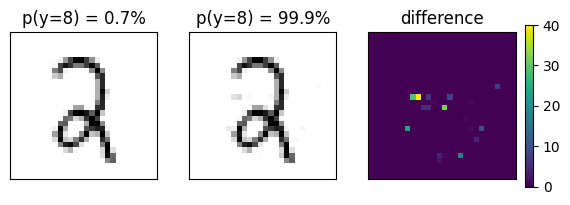

In [10]:
for i in subset:
    base_example = xtest[i, :]
    true_label = ytest_n[i]

    heur = veritas.HeuristicType.MAX_OUTPUT if true_label == class0 \
           else veritas.HeuristicType.MIN_OUTPUT

    config = veritas.Config(heur)
    config.ignore_state_when_worse_than = 0.0

    prune_box = [veritas.Interval(max(0.0, x-eps), min(255, x+eps)) for x in base_example]
    search = config.get_search(at, prune_box)

    tstart = time.time()
    while search.num_solutions() == 0:
        if search.steps(100) == veritas.StopReason.NO_MORE_OPEN:
            break
    tstop = time.time()

    print(f"true_label={true_label}, objective={str(heur)[14:]}",
          f"done in {1000*(tstop-tstart):.2f}ms")

    if search.num_solutions() > 0:
        sol = search.get_solution(0)
        adv_example = veritas.get_closest_example(sol, base_example, eps=1e-3)

        # raw scores
        base_pred_at = at.eval(np.atleast_2d(base_example))[0,0]
        base_pred = model.predict(np.atleast_2d(base_example), output_margin=True)[0]
        adv_pred = model.predict(np.atleast_2d(adv_example), output_margin=True)[0]
        adv_pred_at = at.eval(np.atleast_2d(adv_example))[0,0]

        print(f"    RAW:  {base_pred_at:.4f} -> {adv_pred_at:.4f}")
        print(f"          {base_pred:.4f} -> {adv_pred:.4f}")
        
        # probabilities
        base_prob_at = at.predict(np.atleast_2d(base_example))[0,0]
        base_prob = model.predict_proba(np.atleast_2d(base_example))[0,1]
        adv_prob = model.predict_proba(np.atleast_2d(adv_example))[0,1]
        adv_prob_at = at.predict(np.atleast_2d(adv_example))[0,0]
        
        print(f"    PROB: {base_prob_at:.4f} -> {adv_prob_at:.4f}")
        print(f"          {base_prob:.4f} -> {adv_prob:.4f}")

        fig, ax = plt.subplots(1, 3, figsize=(7, 2.1), width_ratios=[1, 1, 1.25])
        noticks(ax)
        
        ax[0].imshow((base_example).reshape((28,28)), cmap="binary")
        ax[0].set_title(f"p(y={class1}) = {base_prob*100:.1f}%")
        ax[1].imshow((adv_example).reshape((28,28)), cmap="binary")
        ax[1].set_title(f"p(y={class1}) = {adv_prob*100:.1f}%")
        imdiff = ax[2].imshow((adv_example-base_example).reshape((28,28)))
        ax[2].set_title(f"difference")
        fig.colorbar(imdiff, cax=None)
        plt.show()
    else:
        print("no adversarial examples found for", i)
    print()


## An alternative verification question:

Can an image that only has a narrow non-black band in the middle ever get the negative class?

Veritas generated an example in 0.22ms, stop_reason=StopReason.NONE
AddTreeType.GB_BINARY


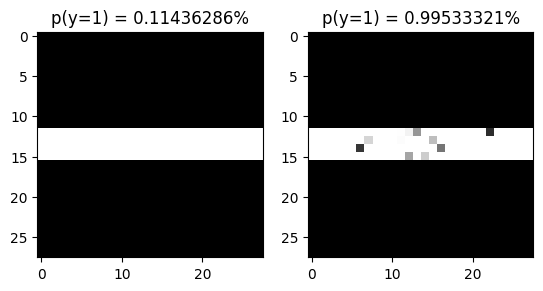

In [11]:
blackband = np.zeros(28*28)
blackband[0:28*12] = 255.0
blackband[28*16:] = 255.0

anything = veritas.Interval(0.0, 255.0)
black = veritas.Interval(255.0, 255.0)

config = veritas.Config(veritas.HeuristicType.MAX_OUTPUT)
config.ignore_state_when_worse_than = 0.0

prune_box = [black if x>0 else anything for x in blackband]
search = config.get_search(at, prune_box)

tstart = time.time()
while search.num_solutions() == 0:
    stop_reason = search.steps(100)
    if stop_reason == veritas.StopReason.NO_MORE_OPEN:
        break
tstop = time.time()

print(f"Veritas generated an example in {1000*(tstop-tstart):.2f}ms, stop_reason={stop_reason}")

sol = search.get_solution(0)
generated = veritas.get_closest_example(sol, blackband, eps=1e-3)

print(at.get_type())

prob_blackband = at.predict(blackband)[0,0]
prob_generated = at.predict(generated)[0,0]

fig, ax = plt.subplots(1, 2)
ax[0].imshow(blackband.reshape((28, 28)), cmap="binary")
ax[0].set_title(f"p(y=1) = {prob_blackband:.8f}%")
ax[1].imshow(generated.reshape((28, 28)), cmap="binary")
ax[1].set_title(f"p(y=1) = {prob_generated:.8f}%")
plt.show()


## Another alternative

Can we find a positive example with non-white pixels only in the top 10 rows of pixels?

Veritas generated an example in 0.07ms, stop_reason=StopReason.OPTIMAL


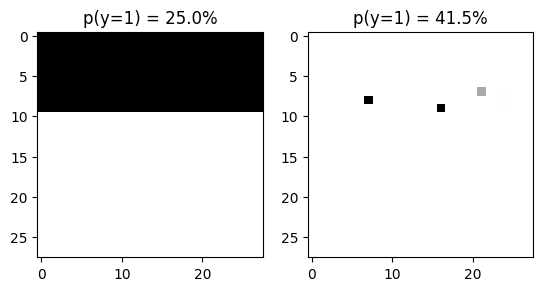

We proved that no such example exists!


In [12]:
allwhite = np.zeros(28*28)
whiteband = np.zeros(28*28)
whiteband[0:28*10] = 255.0

anything = veritas.Interval(0.0, 255.0)
white = veritas.Interval(0.0, 0.0)

config = veritas.Config(veritas.HeuristicType.MAX_OUTPUT)
#config.ignore_state_when_worse_than = 0.0

prune_box = [anything if x>0 else white for x in whiteband]
search = config.get_search(at, prune_box)

tstart = time.time()
while search.num_solutions() == 0:
    stop_reason = search.steps(100)
    if stop_reason == veritas.StopReason.NO_MORE_OPEN:
        break
tstop = time.time()

print(f"Veritas generated an example in {1000*(tstop-tstart):.2f}ms,",
      f"stop_reason={stop_reason}")

if search.num_solutions() > 0:
    sol = search.get_solution(0)
    generated = veritas.get_closest_example(sol, allwhite, eps=1e-3)
    
    prob_whiteband = at.predict(whiteband)[0,0]
    prob_generated = at.predict(generated)[0,0]
    
    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(whiteband.reshape((28, 28)), cmap="binary")
    ax[0].set_title(f"p(y=1) = {prob_whiteband*100:.1f}%")
    ax[1].imshow(generated.reshape((28, 28)), cmap="binary")
    ax[1].set_title(f"p(y=1) = {prob_generated*100:.1f}%")
    plt.show()
    
if search.num_solutions() == 0 or stop_reason == veritas.StopReason.OPTIMAL \
        and prob_generated < 0.5:
    print("We proved that no such example exists!")